In [151]:
from pyspark import SparkContext
import datetime
from csv import reader
import pandas as pd
import numpy as np
import collections
import matplotlib
import matplotlib.pyplot as plt
import sys
%matplotlib inline
matplotlib.style.use('ggplot')

In [152]:
sc = SparkContext()

In [153]:
filepath = r'./data/NYPD_Complaint_Data_Historic.csv'
df = sc.textFile(filepath).map(lambda l: reader([l]).__next__())
header = df.first()
df = df.filter(lambda line: line != header).cache() # filter out header

### Data Cleaning

In [154]:
def transform(array):
    array[1] = datetime.datetime.strptime(array[1], '%m/%d/%Y')
    array[2] = datetime.datetime.strptime(array[2], '%H:%M:%S').time()
    return array

#replace year 1015
def replaceYear2015to2015(array):
    array[1] = array[1].replace('1015', '2015')
    return array

def replaceTime24to00(array):
    array[2] = array[2].replace('24:00:00', '00:00:00')
    return array

t = df.filter(lambda array: array[1] != '' and array[2] != '') \
    .map(replaceYear2015to2015) \
    .map(replaceTime24to00) \
    .map(transform) \
    .filter(lambda array: (array[1].year >= 2006 and array[1].year <= 2015))

In [5]:
def timeMap(x):
    if x[0].hour >= 0 and x[0].hour < 6:
        return ('Midnight',1)
    elif x[0].hour >= 6 and x[0].hour < 12:
        return ('Morning', 1)
    elif x[0].hour >= 12 and x[0].hour < 18:
        return ('Afternoon', 1)
    else:
        return ('Evening', 1)

timeCount = t.map(timeMap) \
            .reduceByKey(lambda x, y: x + y) \

### Assumption 1:  the Time period of a day And the Residence crime

In [6]:
# This operation return the statistic data that crime occur inside the residence
assump_1 = t.map(lambda x: (x[2], x[15], x[16]))\
            .filter(lambda x: 'INSIDE' in str(x[1]) and 'RESIDENCE' in str(x[2]))\
            .map(timeMap)\
            .reduceByKey(lambda x, y: x + y)

In [7]:
assump_1_data = assump_1.collect()

In [8]:
assump_1_data

[('Afternoon', 465993),
 ('Morning', 356396),
 ('Midnight', 243796),
 ('Evening', 469017)]

In [9]:
type(assump_1_data)

list

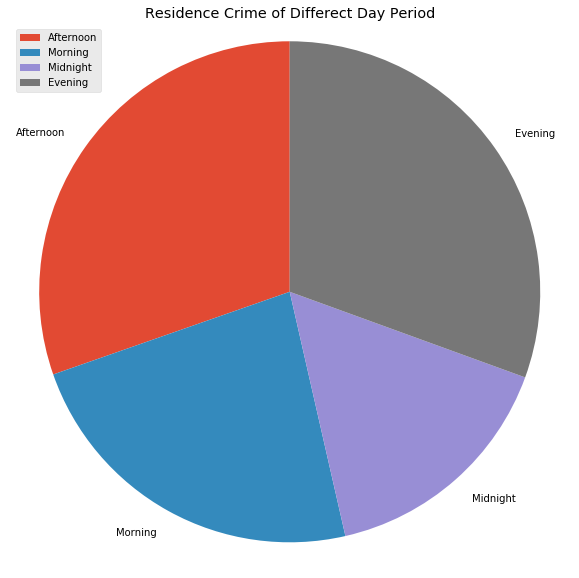

In [237]:
fig, ax = plt.subplots()
ax.pie(np.array(assump_1_data)[:, 1], labels = np.array(assump_1_data)[:, 0], startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Residence Crime of Differect Day Period')
fig.set_size_inches(10, 10)
plt.legend(loc = 2)

### Assumption 2：Time Period and the Street Crime

In [11]:
# This operation return the statistic data that crime occur inside the residence
assump_2 = t.map(lambda x: (x[2], x[16]))\
            .filter(lambda x: 'STREET' in str(x[1]))\
            .map(timeMap)\
            .reduceByKey(lambda x, y: x + y)

In [12]:
assump_2_data = assump_2.collect()

In [13]:
assump_2_data

[('Afternoon', 487580),
 ('Morning', 233245),
 ('Midnight', 351781),
 ('Evening', 623028)]

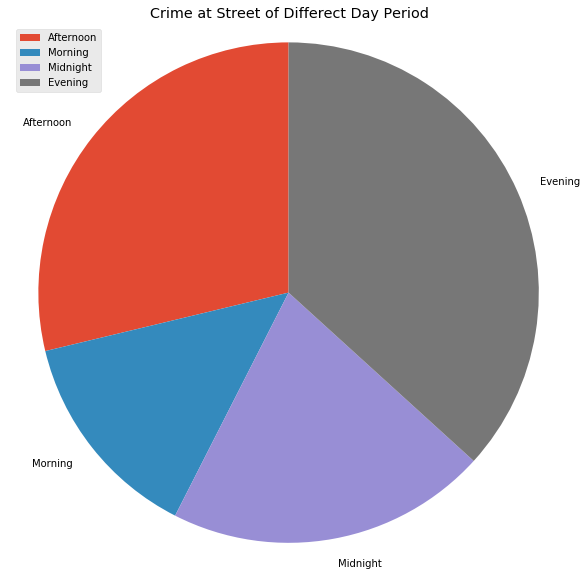

In [236]:
fig, ax = plt.subplots()
ax.pie(np.array(assump_2_data)[:, 1], labels = np.array(assump_2_data)[:, 0], startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Crime at Street of Differect Day Period')
fig.set_size_inches(10, 10)
plt.legend(loc = 2)

### Assumption3: Park and Time Period

In [15]:
# This operation return the statistic data that crime occur inside the residence
assump_3 = t.map(lambda x: (x[2], x[17]))\
            .filter(lambda x: len(x[1]) > 0)\
            .map(timeMap)\
            .reduceByKey(lambda x, y: x + y)

In [16]:
assump_3_data = assump_3.collect()

In [17]:
assump_3_data

[('Afternoon', 3090), ('Morning', 833), ('Midnight', 731), ('Evening', 2945)]

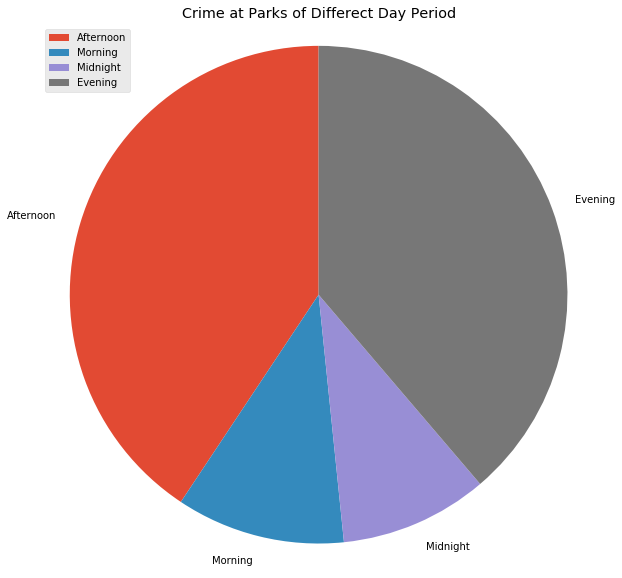

In [235]:
fig, ax = plt.subplots()
ax.pie(np.array(assump_3_data)[:, 1], labels = np.array(assump_3_data)[:, 0], startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Crime at Parks of Differect Day Period')
fig.set_size_inches(10, 10)
plt.legend(loc = 2)

### Assumption4: Residence And Level of offense

In [31]:
assump_4 = t.map(lambda x: (x[11], x[16]))\
            .filter(lambda x: 'RESIDENCE' in x[1])\
            .map(lambda x: (x[0], 1))\
            .reduceByKey(lambda x, y: x + y)

In [32]:
assump_4_data = assump_4.collect()

In [33]:
assump_4_data

[('FELONY', 560415), ('VIOLATION', 354841), ('MISDEMEANOR', 1012439)]

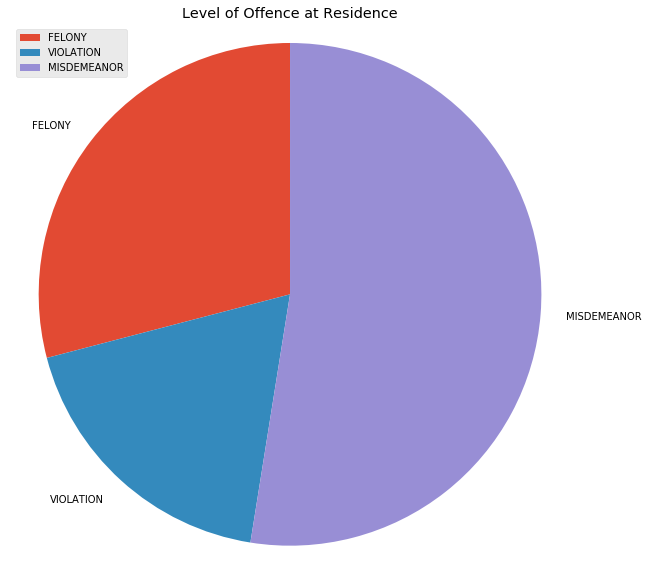

In [231]:
fig, ax = plt.subplots()
ax.pie(np.array(assump_4_data)[:, 1], labels = np.array(assump_4_data)[:, 0], startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Level of Offence at Residence')
fig.set_size_inches(10, 10)
plt.legend(loc = 2)

### Assumption5: Parks And Level of offence

In [39]:
assump_5 = t.map(lambda x: (x[11], x[17]))\
            .filter(lambda x: len(x[1]) > 0)\
            .map(lambda x: (x[0], 1))\
            .reduceByKey(lambda x, y: x + y)

In [40]:
assump_5_data = assump_5.collect()

In [41]:
assump_5_datata

[('FELONY', 2372), ('VIOLATION', 400), ('MISDEMEANOR', 4827)]

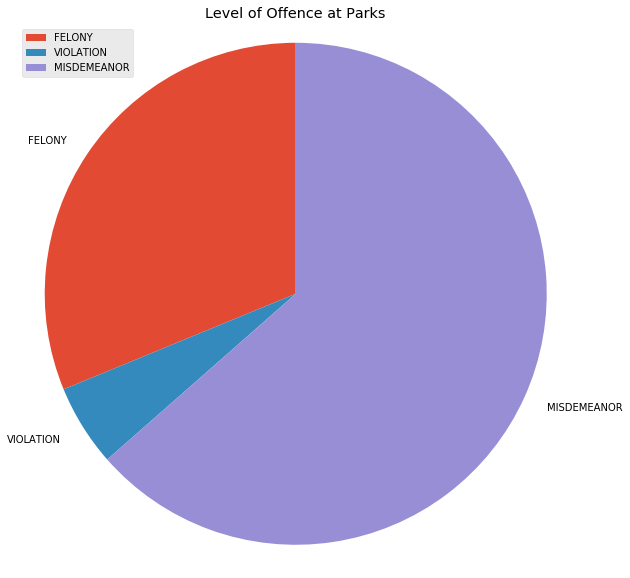

In [230]:
fig, ax = plt.subplots()
ax.pie(np.array(assump_5_data)[:, 1], labels = np.array(assump_5_data)[:, 0], startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Level of Offence at Parks')
fig.set_size_inches(10, 10)
plt.legend(loc = 2)

## Dig into Central Park

### Assumption6: Central Park and Level of offence

In [43]:
assump_6 = t.map(lambda x: (x[11], x[17]))\
            .filter(lambda x: 'CENTRAL PARK' in str(x[1].strip()))\
            .map(lambda x: (x[0], 1))\
            .reduceByKey(lambda x, y: x + y)

In [44]:
assump_6_data = assump_6.collect()

In [46]:
assump_6_data

[('FELONY', 151), ('VIOLATION', 56), ('MISDEMEANOR', 338)]

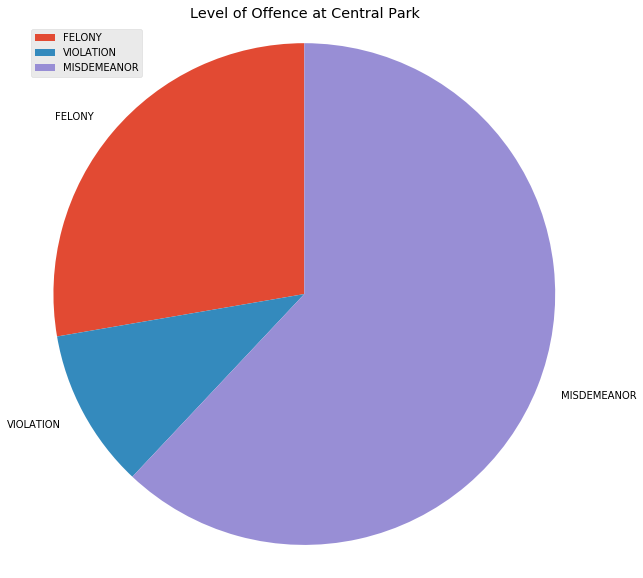

In [229]:
fig, ax = plt.subplots()
ax.pie(np.array(assump_6_data)[:, 1], labels = np.array(assump_5_data)[:, 0], startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Level of Offence at Central Park')
fig.set_size_inches(10, 10)
plt.legend(loc = 2)

### Assumption7: Central Park Weather Information And 

In [177]:
weather_df = pd.read_csv(r'./data/central_park_weather.txt', sep = ' ', header = 0)

In [178]:
weather_df = weather_df[['Unnamed: 3', 'Unnamed: 7']]
weather_df = weather_df.rename(columns = {'Unnamed: 3': 'YEARMODA', 'Unnamed: 7': 'TEMP'}) 

In [191]:
temperature = collections.defaultdict(int)
for value in weather_df.values:
    s = str(int(value[0]))
    year = s[:4]
    month = s[4:6]
    day = s[6:]
    new_s = month + '/' + day + '/' + year
    temperature[datetime.datetime.strptime(new_s, '%m/%d/%Y')] = value[1]
avg_temp = collections.defaultdict(list)
for key, value in temperature.items():
    if np.isnan(value) == False and key.year == 2015:
        avg_temp[key.month] += [value]
for key, value in avg_temp.items():
    avg_temp[key] = sum(value) / len(value)

In [206]:
assump_7 = t.map(lambda x: (x[1], x[17]))\
            .filter(lambda x: x[0] in temperature and 'CENTRAL PARK' in x[1])\
            .filter(lambda x: x[0].year == 2015)\
            .map(lambda x: (x[0].month, 1))\
            .reduceByKey(lambda x, y: x + y)

In [207]:
assump_7_data = assump_7.collect()

In [208]:
assump_7_data

[(1, 12),
 (2, 7),
 (3, 8),
 (4, 29),
 (5, 52),
 (6, 56),
 (7, 62),
 (8, 53),
 (9, 14),
 (10, 22),
 (11, 16),
 (12, 22)]

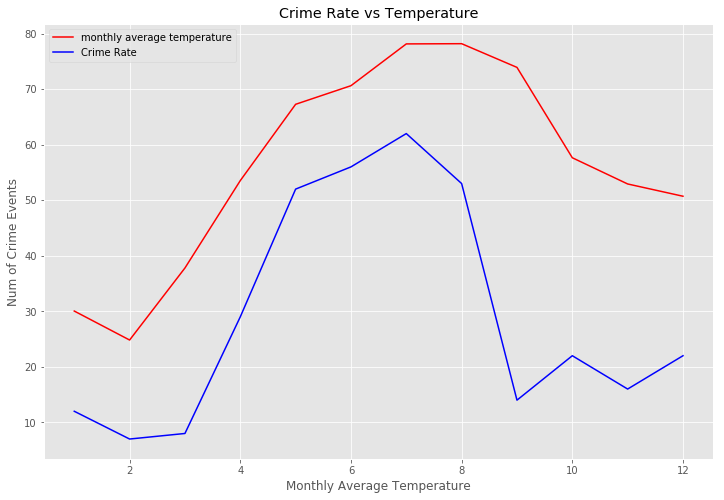

In [225]:
plt.figure(figsize=(12,8))
plt.title('Crime Rate vs Temperature')
plt.xlabel('Monthly Average Temperature')
plt.ylabel('Num of Crime Events')
plt.plot(list(avg_temp.keys()), list(avg_temp.values()), 'r', label='monthly average temperature')
plt.plot(np.array(assump_7_data)[:, 0], np.array(assump_7_data)[:, 1], 'b',label='Crime Rate')
plt.legend(loc = 2)

In [238]:
sc.stop()